# Electricity Customer에 대해서 수행

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import random
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_forecasting.metrics import SMAPE,RMSE,MAE
from captum.attr import IntegratedGradients,NoiseTunnel

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def MSE(pred,target):
    return torch.mean((pred-target)**2,dim = 0) # reduction까지 취해줌

## 1. 모델 구성하기
* 시간단위의 데이터로써 24x30 =720 즉 30일을 바라봄

In [3]:
data = pd.read_csv('../../GeneralData/ElectricityCustomer.csv')
sequence_length = 720
pred_len = 360

In [4]:
data = data.drop(columns='Unnamed: 0')

In [5]:
data = data[['customer1']]

In [6]:
data

,customer1
0,10.152284
1,11.421320
2,11.421320
3,11.421320
4,10.152284
...,...
8756,8.883249
8757,10.152284
8758,7.614213
8759,8.883249


<AxesSubplot: >

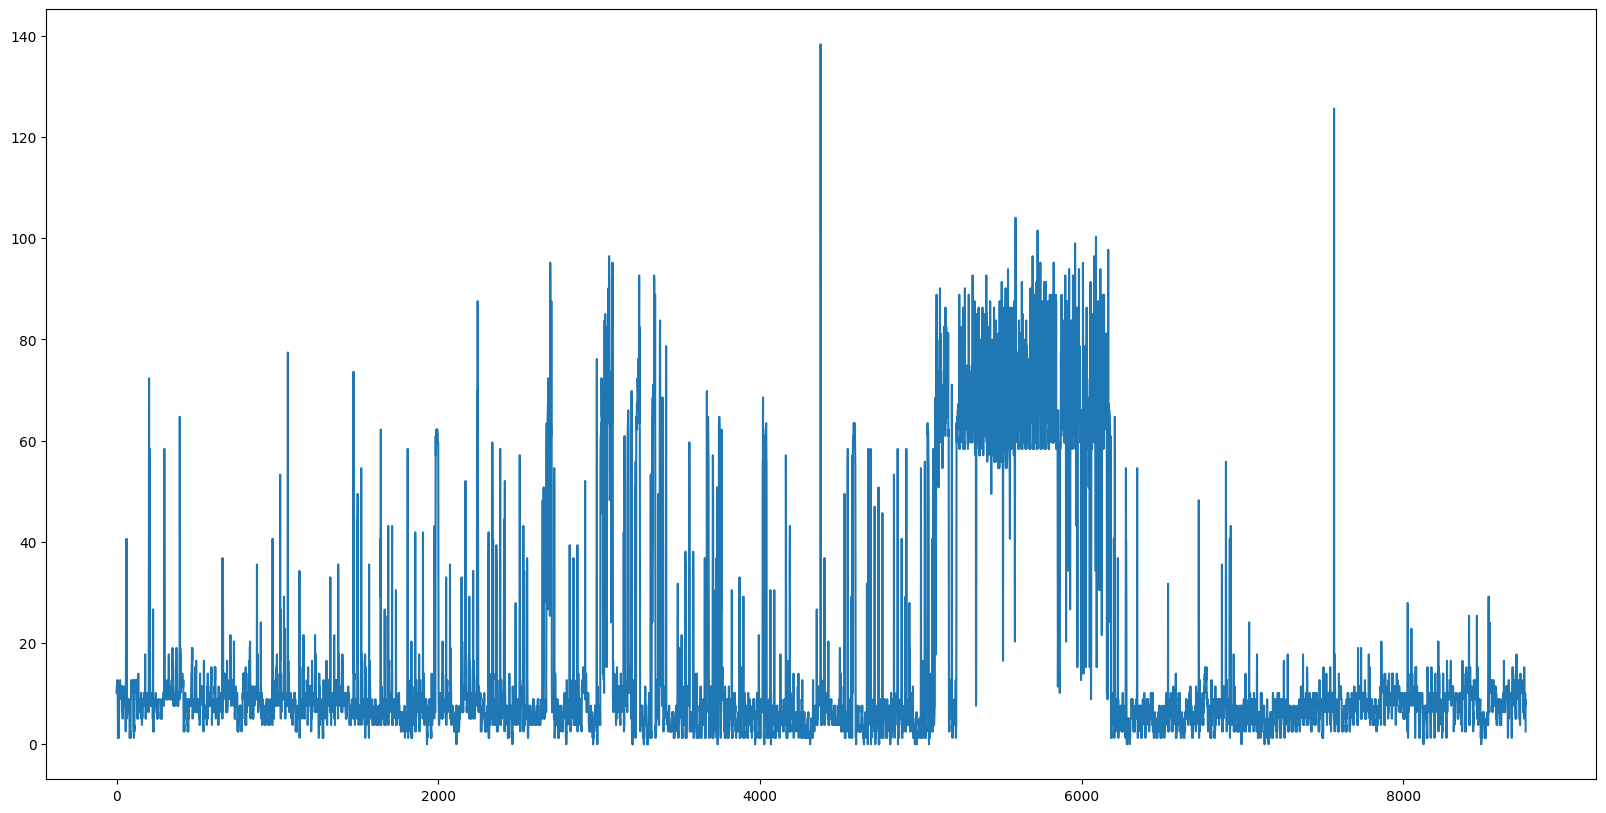

In [7]:
plt.figure(figsize=(20,10))
data['customer1'].plot()

In [8]:
from torch import FloatTensor as FloatTensor

In [9]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(0,len(x)-sequence_length-pred_len+1):
        seq_list.append(x.iloc[i:i+sequence_length].values)
        target_list.append(x.iloc[i+sequence_length:i+sequence_length+pred_len].values)
        
    return FloatTensor(seq_list).view(-1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,pred_len).to(device)

In [10]:
split = 24*7 # 24시간 x 7로써 1주일을 테스트셋으로 만듦

In [11]:
seed = 42

In [12]:
device = torch.device("cuda:0")

In [13]:
class Model(nn.Module):
    def __init__(self,train_index):
        super().__init__()
        self.seq_len = len(train_index)
        self.pred_len = 360
        self.train_index = train_index
        
        self.first_layer = nn.Linear(self.seq_len,self.seq_len//2)
        self.second_layer = nn.Linear(self.seq_len//2,self.seq_len//4)
        self.third_layer = nn.Linear(self.seq_len//4,self.pred_len)
        
        self.first_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.seq_len//2,self.seq_len]))
        self.second_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.seq_len//4,self.seq_len//2]))
        self.third_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len//4]))
    def forward(self,x):
        first_result = self.first_layer(x[:,self.train_index]) 
        second_result = self.second_layer(first_result)
        final_result = self.third_layer(second_result)
        return final_result

# 3. Train-Validation set으로 쪼개기

In [14]:
data

,customer1
0,10.152284
1,11.421320
2,11.421320
3,11.421320
4,10.152284
...,...
8756,8.883249
8757,10.152284
8758,7.614213
8759,8.883249


* 8761개 중 일주일치 데이터인 168개의 데이터를 Test Set
* 8761 중 0.2의 비율인 1752개는 validation set
* 8761개 중 0.8의 비율인 7009개는 train set

In [15]:
val_num = 1752

In [16]:
train = data.iloc[:-split-val_num]
val = data.iloc[-split-val_num:-split]
x_train,y_train = seq_data(train, sequence_length = sequence_length, pred_len = pred_len)
x_val,y_val = seq_data(val, sequence_length = sequence_length, pred_len = pred_len)
train_dataset = TensorDataset(x_train,y_train)
val_dataset = TensorDataset(x_val,y_val)
training = DataLoader(train_dataset,batch_size=64)
validation = DataLoader(val_dataset,batch_size=64)

/tmp/ipykernel_796987/3825588569.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,pred_len).to(device)


In [17]:
train.tail(11)

,customer1
6830,2.538071
6831,11.421320
6832,6.345178
6833,3.807107
6834,3.807107
6835,6.345178
6836,7.614213
6837,7.614213
6838,7.614213
6839,7.614213


In [18]:
y_train.size()

torch.Size([5762, 360])

In [21]:
y_train[-1,-10:]

tensor([11.4213,  6.3452,  3.8071,  3.8071,  6.3452,  7.6142,  7.6142,  7.6142,
         7.6142,  7.6142], device='cuda:0')

In [22]:
next(iter(validation))[0].size()

torch.Size([64, 720])

In [23]:
x_train.size()

torch.Size([5762, 720])

In [24]:
x_val.size()

torch.Size([673, 720])

In [25]:
y_val.size()

torch.Size([673, 360])

### 위와 같은 방식으로 validation-set에 대해서 기여도를 구하면 될 것이다.
-> 모든 batch의 각 sample에 대해서 Ig를 통한 attribution을 구해서 모든 batch에 걸쳐서 더한후 그것을 평균시킨다.<br>
-> 결과적으로 모든 validation set에 대한 attribution을 평균한다.

In [26]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
train_index = np.arange(sequence_length)
model = Model(train_index).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
num_epochs = 100
n= len(training)

### 기본 모델 training

In [27]:
import copy

In [36]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
minimal_loss=np.inf
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
        print(outputs.size())
        outputs = outputs.view(-1,1)    
        labels = labels.view(-1,1)
        
        # defining loss
        loss = MSE(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")

model = best_model

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([2, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size(

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size([64, 360])
torch.Size

KeyboardInterrupt: 

## size를 (-1,1)로 view해도 똑같은 결과가 나옴을 알 수 있다.

In [29]:
output = outputs
label = labels

In [30]:
from sklearn.metrics import mean_squared_error

In [31]:
mean_squared_error(outputs.cpu().detach().numpy(),labels.cpu().detach().numpy())

199.58095

In [32]:
mean_squared_error(output.squeeze(1).cpu().detach().numpy(),label.squeeze(1).cpu().detach().numpy())

199.58095

### validation set에 대해서 attribution 구하기

In [33]:
n = len(validation)
n

11

### attribution 뽑아내는데 대략 20분 소요

In [49]:
cnt = 0
ig = IntegratedGradients(model)
nt_ig = NoiseTunnel(ig)
nt_ig_attr_score = torch.zeros((pred_len,sequence_length)).to(device)
for val in validation: # validation dataloader
    temp_n = val[0].size(0)
    for i in range(pred_len): # target 0에 대한 영향부터 pred_len에 대한 영향까지 모두 더해서 평균적인 영향도를 측정
        temp = nt_ig.attribute(val[0],target=(i,)).sum(axis = 0) # axis=0으로 batch axis를 기준으로 다 더했음 각 feature의 영향도를 계산 위해
        nt_ig_attr_score[i] = nt_ig_attr_score[i]+temp
    cnt = cnt + temp_n
nt_ig_attr_score = nt_ig_attr_score/cnt
nt_ig_attr_score = nt_ig_attr_score.mean(axis = 0)
nt_ig_attr_score = nt_ig_attr_score.cpu().numpy().reshape(-1)

In [48]:
print(temp.size()) # sum하기전에 형태

torch.Size([64, 720])


In [52]:
len(nt_ig_attr_score)

720

<AxesSubplot: >

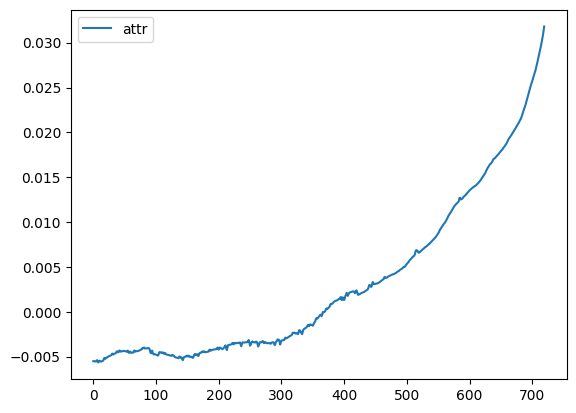

In [53]:
attr_df = pd.DataFrame({'attr':nt_ig_attr_score})
attr_df.plot()

### &rightarrow; 최근데이터가 매우강조 되는것을 확인할 수 있다.

#### scaling

* 표준화는 데이터가 정규분포를 따른다고 가정해야지 1sigma와 -1sigma에 68%정도의 데이터가 모여있음
* 데이터를 z-score로 변환(즉, 데이터를 표준화 또는 정규화)한다고 해서 데이터가 정규분포가 되는 것은 아니다. 단지 비교를 목적으로 데이터를 표준정규분포와 같은 척도로 만드는 것 뿐이다.
* 결과적으로 원래 정규분포의 형태였던 분포를 공통척도(평균은 0 표준편차는 1)로 바꾸는 것

https://hleecaster.com/ml-normalization-concept/

## 아무런 Scaling을 하지 않았을때

<AxesSubplot: >

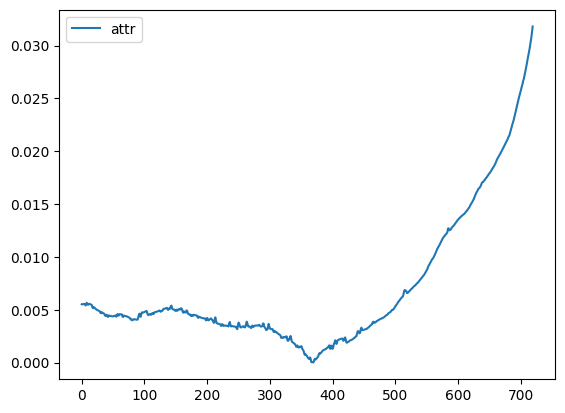

In [54]:
attr_df = attr_df.abs()
attr_df.plot()

## Outlier정의 계수(1.5)도 파라미터로 정할수 있도록

In [55]:
IQR = 1.5*(attr_df.quantile(0.75)-attr_df.quantile(0.25))
outlier_max = attr_df.quantile(0.75)+IQR
outlier_min = attr_df.quantile(0.25)-IQR
candidate_attr = attr_df[(attr_df>=outlier_min) & (attr_df<=outlier_max)]
candidate_attr = candidate_attr.dropna()
candidate_attr

,attr
0,0.005521
1,0.005502
2,0.005525
3,0.005545
4,0.005560
...,...
610,0.014069
611,0.014158
612,0.014226
613,0.014279


In [56]:
outlier_max

attr    0.014418
dtype: float64

In [57]:
outlier_min

attr   -0.003202
dtype: float64

<AxesSubplot: >

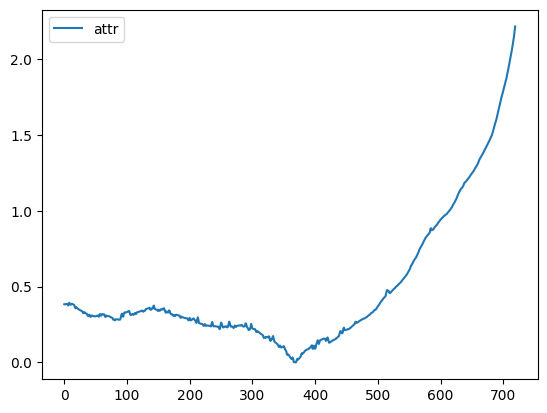

In [58]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
scaler.fit(candidate_attr.values)
m_attr_df = scaler.transform(attr_df.values)
m_attr_df = pd.DataFrame({"attr":m_attr_df.reshape(-1)})
# attr_df = attr_df.abs()
# attr_std = attr_df.std().item()
# attr_min = attr_df.min().item()
m_attr_df.plot()

In [59]:
m_attr_df.describe()

,attr
count,720.000000
mean,0.491574
std,0.456759
min,0.000000
25%,0.236491
50%,0.312879
75%,0.543407
max,2.215208


## 0과 1사이의 분포 확인하기

In [60]:
m_attr_df[(m_attr_df>=0) & (m_attr_df<=1)].dropna()

,attr
0,0.383851
1,0.382542
2,0.384162
3,0.385591
4,0.386583
...,...
610,0.979450
611,0.985617
612,0.990407
613,0.994085


* outlier를 제외하면 들어와있음을 확인할 수 있다.

<AxesSubplot: >

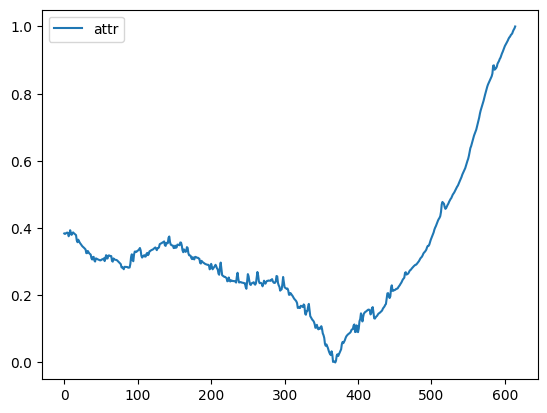

In [61]:
m_attr_df[(m_attr_df>=0) & (m_attr_df<=1)].dropna().plot()

### MinMaxScaler와 비교

<AxesSubplot: >

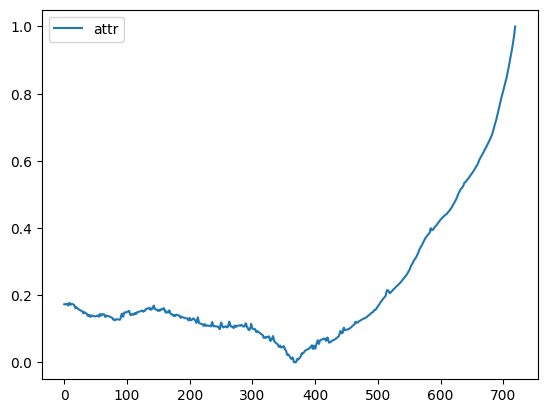

In [63]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
attr_df = scaler.fit_transform(attr_df.values)
attr_df = pd.DataFrame({"attr":attr_df.reshape(-1)})
# attr_df = attr_df.abs()
# attr_std = attr_df.std().item()
# attr_min = attr_df.min().item()
attr_df.plot()

#### train_index구하기

In [64]:
index_list = []

for hyper_para in np.arange(0.00,1.01,0.01):
    append_idx = list(m_attr_df[(m_attr_df['attr']>=hyper_para)].index)
    index_list.append(append_idx)
len(index_list) # train_index의 리스트

101

In [65]:
len_list=[]
for i in range(101):
    len_list.append(len(index_list[i]))


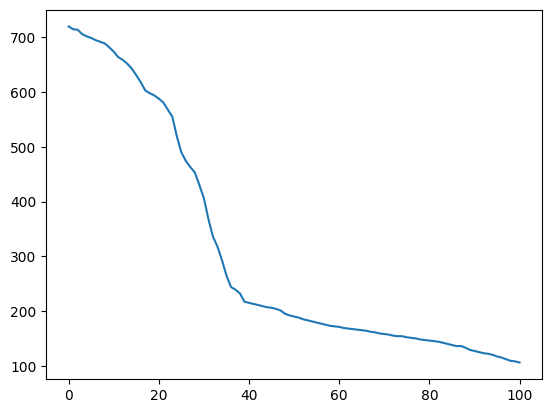

In [66]:
plt.plot(np.arange(101),len_list) # 포함되는 time_index의 갯수

In [67]:
### 원래 난수가 선언된 위치
m = len(validation)
n = len(training)
cnt = 0
mse_out_list = []
mae_out_list = []
smape_out_list = []
rmse_out_list = []
num_epochs = 100
for idx in index_list: #0.01~1.00 100개의 index에 대해서 수행
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
    train_idx = idx
    minimal_loss=np.inf
    model = Model(train_idx).to(device) # 모델 초기화
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer 초기화
    result = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in training:
            # forward pass
            inputs = inputs
            
            outputs = model(inputs)
            outputs = outputs.view(-1,1)
            labels = labels.view(-1,1)            
            # defining loss
            loss = MSE(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch == 99:    
            print(f'{cnt}번째 모델 Training 완료 마지막 Epoch loss:{(running_loss/n)*100}')
        
        if (running_loss/n)*100<minimal_loss:
            best_model = copy.deepcopy(model)
            minimal_loss = (running_loss/n)*100
            print("changed")

    model = best_model
    cnt+=1
    # 모델 Fully-Training 완료
    
    pred = torch.FloatTensor().to(device)
    val_target = torch.FloatTensor().to(device)
    for val_x,val_y in validation:
        tmp_pred = model(val_x)
        pred = torch.concat([pred,tmp_pred], dim=0)
        val_target = torch.concat([val_target,val_y],dim = 0)
    pred = pred.view(-1,1)
    val_target = val_target.view(-1,1)
    result = MSE(pred,val_target).item()
    mse_out_list.append(result)
    mae_out_list.append(MAE()(pred,val_target).item())
    rmse_out_list.append(RMSE()(pred,val_target).item())
    smape_out_list.append(SMAPE()(pred,val_target).item()*100)

changed
changed
changed
changed
changed
0번째 모델 Training 완료 마지막 Epoch loss:45491.83785993975
changed
changed
changed
changed
changed
1번째 모델 Training 완료 마지막 Epoch loss:47660.37191034673
changed
changed
changed
changed
changed
2번째 모델 Training 완료 마지막 Epoch loss:46620.04558437473
changed
changed
changed
changed
changed
3번째 모델 Training 완료 마지막 Epoch loss:44994.949412083886
changed
changed
changed
changed
changed
4번째 모델 Training 완료 마지막 Epoch loss:45937.02875493647
changed
changed
changed
changed
changed
5번째 모델 Training 완료 마지막 Epoch loss:47953.32756880875
changed
changed
changed
changed
changed
6번째 모델 Training 완료 마지막 Epoch loss:46493.84765205802
changed
changed
changed
changed
changed
7번째 모델 Training 완료 마지막 Epoch loss:44976.24294155247
changed
changed
changed
changed
changed
8번째 모델 Training 완료 마지막 Epoch loss:45972.15047563826
changed
changed
changed
changed
changed
9번째 모델 Training 완료 마지막 Epoch loss:45496.81303422529
changed
changed
changed
changed
changed
10번째 모델 Training 완료 마지막 Epoch loss:4481

37번째 모델 Training 완료 마지막 Epoch loss:43884.865737747365
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
38번째 모델 Training 완료 마지막 Epoch loss:43933.796455047945
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
chan

changed
changed
changed
changed
47번째 모델 Training 완료 마지막 Epoch loss:45220.68464258215
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
48번째 모델 Training 완료 마지막 Epoch loss:45134.36295645578
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
change

changed
changed
changed
changed
changed
changed
changed
changed
changed
57번째 모델 Training 완료 마지막 Epoch loss:44865.73308169187
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
58번째 모델 Training 완료 마지막 Epoch loss:44860.12372027387
changed
changed
changed
changed
change

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
67번째 모델 Training 완료 마지막 Epoch loss:44712.25605010986
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
77번째 모델 Training 완료 마지막 Epoch loss:44507.286216400484
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
ch

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
87번째 모델 Training 완료 마지막 Epoch loss:44245.400101797924
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
ch

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
96번째 모델 Training 완료 마지막 Epoch loss:43803.99777967852
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

In [68]:
val_y # 다음 예측 타겟값

tensor([[ 6.3452,  8.8832,  7.6142,  ...,  8.8832, 12.6904, 12.6904],
        [ 8.8832,  7.6142, 10.1523,  ..., 12.6904, 12.6904, 10.1523],
        [ 7.6142, 10.1523,  8.8832,  ..., 12.6904, 10.1523,  8.8832],
        ...,
        [ 7.6142,  6.3452,  8.8832,  ...,  7.6142,  7.6142,  8.8832],
        [ 6.3452,  8.8832,  6.3452,  ...,  7.6142,  8.8832,  6.3452],
        [ 8.8832,  6.3452,  7.6142,  ...,  8.8832,  6.3452,  8.8832]],
       device='cuda:0')

In [69]:
val_x # 예측 하는 값

tensor([[ 5.0761,  7.6142,  7.6142,  ..., 13.9594, 13.9594, 10.1523],
        [ 7.6142,  7.6142,  8.8832,  ..., 13.9594, 10.1523,  6.3452],
        [ 7.6142,  8.8832,  8.8832,  ..., 10.1523,  6.3452,  8.8832],
        ...,
        [11.4213,  8.8832, 11.4213,  ...,  7.6142,  7.6142,  7.6142],
        [ 8.8832, 11.4213, 10.1523,  ...,  7.6142,  7.6142,  7.6142],
        [11.4213, 10.1523, 11.4213,  ...,  7.6142,  7.6142,  6.3452]],
       device='cuda:0')

In [70]:
result/68

0.19838463558870204

In [71]:
val_x.size()

torch.Size([33, 720])

          out
97  13.476277


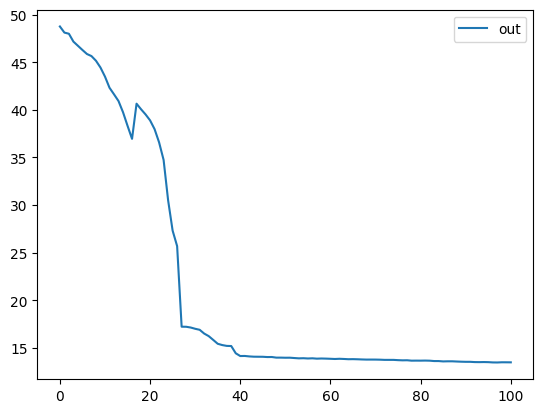

In [72]:
out_df = pd.DataFrame({"out":mse_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [73]:
out_df 

,out
0,48.754822
1,48.113224
2,47.991730
3,47.164429
4,46.727123
...,...
96,13.482138
97,13.476277
98,13.497128
99,13.494909


         out
97  2.753972


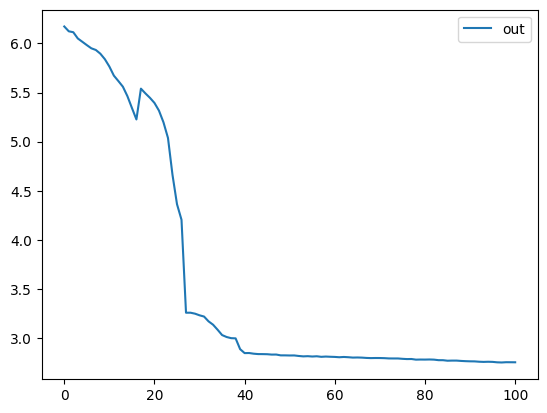

In [74]:
out_df = pd.DataFrame({"out":mae_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [75]:
out_df 

,out
0,6.171756
1,6.122715
2,6.113350
3,6.049853
4,6.016212
...,...
96,2.755563
97,2.753972
98,2.756730
99,2.756305


          out
97  36.222675


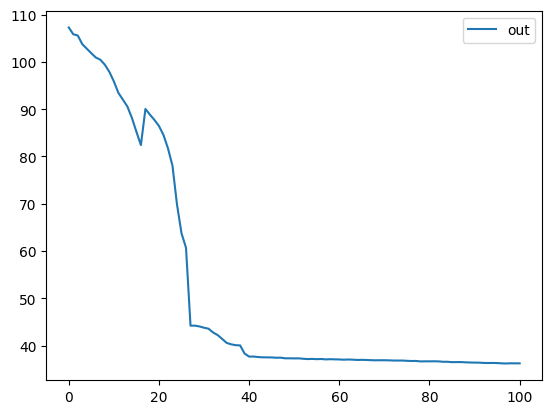

In [76]:
out_df = pd.DataFrame({"out":smape_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [77]:
out_df 

,out
0,107.269013
1,105.837715
2,105.564713
3,103.740633
4,102.784395
...,...
96,36.247650
97,36.222675
98,36.261809
99,36.254022


         out
97  3.671005


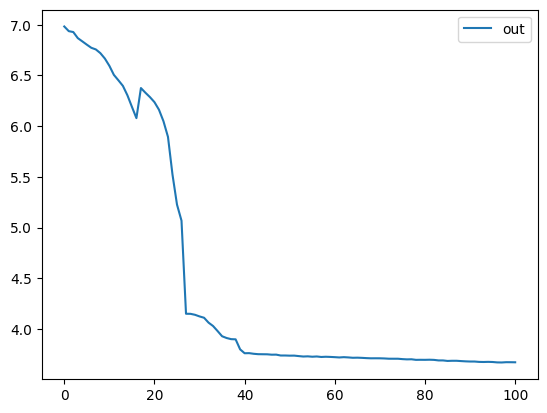

In [78]:
out_df = pd.DataFrame({"out":rmse_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [79]:
out_df 

,out
0,6.982466
1,6.936370
2,6.927607
3,6.867636
4,6.835724
...,...
96,3.671803
97,3.671005
98,3.673844
99,3.673542


In [80]:
attr_df.describe()

,attr
count,720.000000
mean,0.221909
std,0.206192
min,0.000000
25%,0.106758
50%,0.141242
75%,0.245307
max,1.000000
